In [ ]:
import pandas as pd 
import numpy as np 
import evoVAE.utils.metrics as mt 
import evoVAE.utils.seq_tools as st
from numba import njit, prange, jit
import random
#pd.set_option('display.max_rows', None)

In [ ]:
PATH = "/Users/sebs_mac/git_repos/dms_data/DMS_ProteinGym_substitutions/A4_HUMAN_Seuma_2022.csv"

def split_by_mutations(dms_data):
    """
    Create a subset of the mutation DataFrames based on how many mutations
    are in the variant.

    Return:
    A dictionary mapping mutation count to subset dataframe
    """

    # define a function for counting mutations
    splitter = lambda x: len(x.split(":"))
    dms_data["mut_count"] = dms_data["mutant"].apply(splitter)

    subframes = dict()
    for count in dms_data["mut_count"].unique():
        subframes[count] = dms_data.loc[dms_data["mut_count"] == count]

    return subframes

dms = pd.read_csv(PATH)
dms.head()

subframe = split_by_mutations(dms)
subframe[2].shape

In [ ]:
#aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants_no_dupes.fasta", encode=False)
aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_no_dupes.fasta", encode=False)
#aln.drop(columns=["encoding"], inplace=True)
#aln.head()
aln.to_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_no_dupes.pkl")

In [ ]:
aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.pkl")
aln.head()

# GB1 clustering 

In [ ]:
aln: pd.DataFrame = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/encoded_weighted/gb1_ancestors_extants_encoded_weighted_no_dupes.pkl")
aln = aln.drop_duplicates(subset=['sequence'])
#aln = aln.sample(frac=0.2)
aln.drop(columns=["encoding", "weights"], inplace=True)
print(aln.shape)
aln.head()

msa, seq_key, key_label = st.convert_msa_numpy_array(aln)
msa.shape

In [ ]:
aln.head()

In [ ]:
st.write_fasta_file("gb1_ancestors_extants_no_dupes.fasta", aln)

In [ ]:
results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/mmseqs_clustering/gb1_an_ex_cluster.tsv", sep="\t", header=None)
results.columns = ["cluster", "sequence"]
mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = results["sequence"].apply(mark_ancestors)
results["is_ancestor"] = is_ancestor

representative_ids = results["cluster"].unique()
clusters = [results.loc[results["cluster"] == cluster] for cluster in representative_ids]
representative_ids.shape


In [ ]:
results.loc[results["is_ancestor"] == 0].shape

In [ ]:
SAMPLE_SIZE = 100
extant_proportions = [0.15, 0.10, 0.05, 0.0]


random.seed(42)

for p in extant_proportions:
    
    all_indices = []
    reps = []

    for r in range(1, 5):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        all_indices.append(indices)
        reps.append(r)

    test = pd.DataFrame({"replicate": reps, "indices": all_indices})
    test.to_csv(f"gb1_{p}_replicates.csv", index=False)

#st.write_fasta_file(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

In [ ]:
test = pd.read_csv("gb1_0.0_replicates.csv", )

indices = test.loc[
    test["replicate"] == 3, "indices"
].values[0]

indices = [int(x.strip()) for x in indices[1:-1].split(",")]
print(indices[:10])

thing = aln.loc[indices]


In [ ]:
numpy_aln, _, _ = st.convert_msa_numpy_array(thing)
weights = st.reweight_by_seq_similarity(numpy_aln, 0.2)
one_hot = thing["sequence"].apply(st.seq_to_one_hot)
thing["weights"] = weights
thing["encoding"] = one_hot

In [ ]:
thing.head()

In [ ]:
for p in extant_proportions:
    for r in range(1, 2):
        samp_aln = aln.loc[indices]
        numpy_aln, _, _ = st.convert_msa_numpy_array(samp_aln)
        weights = st.reweight_by_seq_similarity(numpy_aln, 0.2)
        samp_aln["weights"] = weights
        print(samp_aln.head())
        #samp_aln.to_pickle(f"./clusters/gb1_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}_encoded_weighted.pkl")


In [ ]:
test = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gb1/mmseqs_clustering/replicate_encoded_weighted/gb1_ancestors_extants_no_dupes_clustered_r1_extant_0.12_encoded_weighted.pkl")
test.loc[~test["id"].str.contains("tree")]

#### Results

In [ ]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/a4_cluster_rnd2/"

df_list = [pd.read_csv((DATA_PATH + str(file) + "/zero_shot.csv")) for file in os.listdir(DATA_PATH) if file != ".DS_Store"]


In [ ]:
df_list[0].head()

In [ ]:

#all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
all_data = pd.concat(df_list, ignore_index=True)
all_data.drop(columns=["Unnamed: 0"], inplace=True)

get_rep = lambda x: x.split("/")[1].split("_")[3][1]
get_ex = lambda x: x.split("/")[1].split("_")[1] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

all_proportions = all_data["extant_prop"].unique()
all_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]

In [ ]:
all_data.head()

In [ ]:
all_proportions

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt


points = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]
labels = all_proportions


metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc"]#, "covariance"]
for m in metrics:
    means = [point[m].mean() for point in points]
    std_devs = [point[m].std() for point in points] 

    x_pos = np.arange(len(labels))

    fig, ax = plt.subplots()

    # Create bars
    bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

    for i, point in enumerate(points):
        ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


    # Add labels
    ax.set_xlabel('Extant sample proportion')
    ax.set_ylabel(f'Mean {m}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)

    #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
    ax.set_title(f'A4: Average {m} with Ancestor/Extant samples')


    # Add a grid for better readability
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    #plt.savefig('Average Spearman\'s Rank Correlation with Ancestor samples')
    plt.show()

# A4 human clustering 

In [ ]:
clustering_results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/mmseqs_clustering/a4_an_ex_cluster.tsv", sep="\t", header=None)
clustering_results.columns = ["cluster", "sequence"]

mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = clustering_results["sequence"].apply(mark_ancestors)
clustering_results["is_ancestor"] = is_ancestor

representative_ids = clustering_results["cluster"].unique()

clustering_results


In [ ]:
aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants.fasta")

encodings, weights = st.encode_and_weight_seqs(aln, 0.2)

aln["encoding"] = encodings
aln["weights"] = weights
aln
aln 

In [ ]:
aln.to_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_extants_encoded_weighted.pkl")

In [ ]:
aln.to_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_extants_encoded_weighted.pkl")

In [ ]:
clustering_results[clustering_results["is_ancestor"] == 0]

In [ ]:
clusters = [clustering_results.loc[clustering_results["cluster"] == rep] for rep in representative_ids]
len(clusters)

In [ ]:
SAMPLE_SIZE = 10000
extant_proportions = [0.2185, 0.15, 0.1, 0.05, 0.0]


aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/a4_human/alns/a4_ancestors_extants_no_dupes.fasta", encode=False)

random.seed(42)

for p in extant_proportions:
    for r in range(1, 6):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        st.write_fasta_file(f"./a4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta", sample_seqs)

In [ ]:
for p in extant_proportions:
    for r in range(1, 6):
        samp_aln = st.read_aln_file(f"./a4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta")
        numpy_aln, _, _ = st.convert_msa_numpy_array(samp_aln)
        weights = st.reweight_by_seq_similarity(numpy_aln, 0.2)
        samp_aln["weights"] = weights
        samp_aln.to_pickle(f"a4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}_encoded_weighted.pkl")

In [ ]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/clustering_data/a4/"

df_list = [pd.read_csv((DATA_PATH + str(file) + "/_zero_shot.csv")) for file in os.listdir(DATA_PATH) if str(file) != ".DS_Store"]

all_data = pd.concat(df_list, ignore_index=True)

#all_data = pd.read_csv("gcn4_cluster_sampling_results.csv")
all_data.drop(columns=["Unnamed: 0"], inplace=True)


get_rep = lambda x: x.split("_")[1] 
get_ex = lambda x: x.split("_")[11] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

all_proportions = all_data["extant_prop"].unique()
all_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]


In [ ]:
all_data

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

points = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]
labels = all_proportions

means = [point["roc_auc"].mean() for point in points]
std_devs = [point["roc_auc"].std() for point in points] 

x_pos = np.arange(len(labels))

fig, ax = plt.subplots()

# Create bars
bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

for i, point in enumerate(points):
    ax.scatter([i]*len(point), point["roc_auc"], color='red', zorder=3, alpha=0.5)


# Add labels
ax.set_xlabel('Extant sample proportion (%)')
ax.set_ylabel('Mean roc_auc')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

#ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
ax.set_title('Average roc_auc with Ancestor/Extant samples')


# Add a grid for better readability
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('Average Spearman\'s Rank Correlation with Ancestor samples')
plt.show()

In [ ]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/gb1_standard_results/"

df_list = [pd.read_csv((DATA_PATH + str(file) + "/zero_shot.csv")) for file in os.listdir(DATA_PATH) if file != ".DS_Store"]


#all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
all_data = pd.concat(df_list, ignore_index=True)
all_data.drop(columns=["Unnamed: 0"], inplace=True)
all_data.head()

In [ ]:

get_rep = lambda x: x.split("/")[1].split("_")[-1] 
#get_ex = lambda x: x.split("/")[1].split("_")[1] 

rep = all_data["unique_id"].apply(get_rep)

def get_ex(thing):
    data = thing.split("/")[1].split("_")

    if len(data) == 3:
        return data[1]
    elif len(data) == 4:
        return "_".join(data[1:3])

ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["sample"] = ext_prop

all_proportions = all_data["sample"].unique()
all_proportions.sort()

subsets = [all_data.loc[all_data["sample"] == prop] for prop in all_proportions]

import numpy as np 
import matplotlib.pyplot as plt

points = [all_data.loc[all_data["sample"] == prop] for prop in all_proportions]
labels = all_proportions


metrics = ["spearman_rho", "top_k_recall", "ndcg", "roc_auc"]#, "covariance"]
for m in metrics:
    means = [point[m].mean() for point in points]
    std_devs = [point[m].std() for point in points] 

    x_pos = np.arange(len(labels))

    fig, ax = plt.subplots()

    # Create bars
    bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

    for i, point in enumerate(points):
        ax.scatter([i]*len(point), point[m], color='red', zorder=3, alpha=0.5)


    # Add labels
    ax.set_xlabel('Extant sample proportion')
    ax.set_ylabel(f'Mean {m}')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)

    #ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
    ax.set_title(f'GB1: Average {m} with Ancestor/Extant samples')


    # Add a grid for better readability
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    #plt.savefig('Average Spearman\'s Rank Correlation with Ancestor samples')
    plt.show()

# GCN4 clustering

In [ ]:
clustering_results = pd.read_csv("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/mmseqs_clustering/gcn4_an_ex_cluster.tsv", sep="\t", header=None)
clustering_results.columns = ["cluster", "sequence"]

mark_ancestors = lambda x: 1 if "tree" in x else 0
is_ancestor = clustering_results["sequence"].apply(mark_ancestors)
clustering_results["is_ancestor"] = is_ancestor

representative_ids = clustering_results["cluster"].unique()

clustering_results


In [ ]:
clustering_results[clustering_results["is_ancestor"] == 0].shape, clustering_results[clustering_results["is_ancestor"] == 1].shape 

In [ ]:
# divide the sequences into their clusters
clusters = [clustering_results.loc[clustering_results["cluster"] == rep] for rep in representative_ids]
len(clusters)

In [ ]:
# remove duplcates 

# aln = st.read_aln_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants.fasta", encode=False)
# aln = aln.drop_duplicates(subset=["sequence"])
# aln
# st.write_fasta_file("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.fasta", aln)

In [ ]:
aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.pkl")



In [ ]:
import random
import evoVAE.utils.seq_tools as st


SAMPLE_SIZE = 5000
extant_proportions = [0.06, 0.04, 0.02, 0.0]


aln = pd.read_pickle("/Users/sebs_mac/uni_OneDrive/honours/data/gcn4/alns/gcn4_ancestors_extants_no_dupes.pkl")

random.seed(42)

for p in extant_proportions:
        
    test = pd.DataFrame()

    for r in range(1, 16):
        sample_ids = st.sample_extant_ancestors(clusters, SAMPLE_SIZE, extant_proportion=p)
        sample_seqs = aln.loc[aln["id"].isin(sample_ids)]
        indices =  list(sample_seqs.index)
        test[f"rep_{r}"] = indices


    test.to_csv(f"gcn4_{p}_replicates.csv", index=False)
       


In [ ]:
for p in extant_proportions:
    for r in range(1, 6):
        samp_aln = st.read_aln_file(f"./gcn4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}.fasta")
        numpy_aln, _, _ = st.convert_msa_numpy_array(samp_aln)
        weights = st.reweight_by_seq_similarity(numpy_aln, 0.2)
        samp_aln["weights"] = weights
        samp_aln.to_pickle(f"gcn4_ancestors_extants_no_dupes_clustered_r{r}_extant_{p}_encoded_weighted.pkl")

In [ ]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/uni_OneDrive/honours/data/clustering_data/gcn4/"

#df_list = [pd.read_csv(file + "/_zero_shot.csv") for file in os.listdir(DATA_PATH)]
df_list = [pd.read_csv((DATA_PATH + str(file) + "/_zero_shot.csv")) for file in os.listdir(DATA_PATH) if str(file) != ".DS_Store"]

all_data = pd.read_csv("gcn4_cluster_sampling_results.csv")
all_data.drop(columns=["Unnamed: 0"], inplace=True)

get_rep = lambda x: x.split("_")[1] 
get_ex = lambda x: x.split("_")[11] 

rep = all_data["unique_id"].apply(get_rep)
ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data["extant_prop"] = ext_prop

all_proportions = all_data["extant_prop"].unique()
all_proportions.sort()

subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]



In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

points = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]
labels = all_proportions

means = [point["covariance"].mean() for point in points]
std_devs = [point["covariance"].std() for point in points] 

x_pos = np.arange(len(labels))

fig, ax = plt.subplots()

# Create bars
bars = ax.bar(x_pos, means, yerr=std_devs, align='center', alpha=0.7, ecolor='black', capsize=10)

for i, point in enumerate(points):
    ax.scatter([i]*len(point), point["covariance"], color='red', zorder=3, alpha=0.5)


# Add labels
ax.set_xlabel('Extant sample proportion (%)')
ax.set_ylabel('Mean pairwise_covariance')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)

#ax.set_title('Average Spearman\'s Rank Correlation with Ancestor/Extant samples')
ax.set_title('Average pairwise covariance with Ancestor/Extant samples')


# Add a grid for better readability
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
#plt.savefig('Average Spearman\'s Rank Correlation with Ancestor samples')
plt.show()

# Alternate clustering: incomplete

In [ ]:

test = st.read_aln_file("../data/pair_test.aln")
test_msa, _, _ = st.convert_msa_numpy_array(test)

@njit(parallel=True)
def adj_matrix(msa) -> np.ndarray:

    sim_matrix = np.ones((msa.shape[0], msa.shape[0]))
    seq_len = len(msa[0])

    for i in prange(msa.shape[0]):
        for j in prange(i + 1, msa.shape[0]):
            dist = 1 - (mt.hamming_distance(msa[i], msa[j]) / seq_len)
            sim_matrix[i, j] = sim_matrix[j, i] = dist 


    return sim_matrix

adj_matrix(test_msa)


In [ ]:
mat = adj_matrix(msa)

In [ ]:
clustering.n_leaves_

In [ ]:
st.write_fasta_file(data+"a4_ancestors_extants_no_dupes.fasta", seqs)

In [ ]:
data

In [1]:
import os
import pandas as pd

DATA_PATH = "/Users/sebs_mac/a4_latent_test/"

df_list = [pd.read_csv((DATA_PATH + str(file) + "/zero_shot_all_variants_final_metrics.csv")) for file in os.listdir(DATA_PATH) if file != ".DS_Store"]
df_list[0]

,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc
0,./11_dims/,0.098728,0.138327,0.622981,0.55247


In [2]:

#all_data = pd.read_csv("gb1_cluster_sampling_results.csv")
all_data = pd.concat(df_list, ignore_index=True)

get_rep = lambda x: int(x.split("/")[1].split("_")[0])
# get_ex = lambda x: x.split("/")[1].split("_")[1] 

rep = all_data["unique_id"].apply(get_rep)
# ext_prop = all_data["unique_id"].apply(get_ex)
all_data["replicate"] = rep
all_data.sort_values(by="replicate", inplace=True)

# all_data["extant_prop"] = ext_prop

# all_proportions = all_data["extant_prop"].unique()
# all_proportions.sort()

#subsets = [all_data.loc[all_data["extant_prop"] == prop] for prop in all_proportions]
all_data

,unique_id,spearman_rho,top_k_recall,ndcg,roc_auc,replicate
8,./3_dims/,0.161216,0.152497,0.647502,0.579191,3
6,./4_dims/,0.145590,0.163968,0.620286,0.572604,4
5,./5_dims/,0.131367,0.165317,0.659463,0.564677,5
3,./6_dims/,0.184977,0.153846,0.676009,0.596127,6
2,./7_dims/,0.216492,0.170715,0.624629,0.611091,7
7,./8_dims/,0.186227,0.168691,0.645336,0.589229,8
4,./9_dims/,0.167842,0.157895,0.658692,0.587877,9
1,./10_dims/,0.173395,0.172065,0.625322,0.582412,10
0,./11_dims/,0.098728,0.138327,0.622981,0.552470,11
9,./12_dims/,0.038709,0.148448,0.632259,0.507160,12


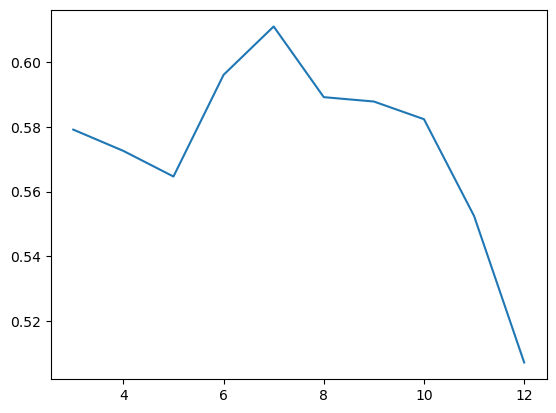

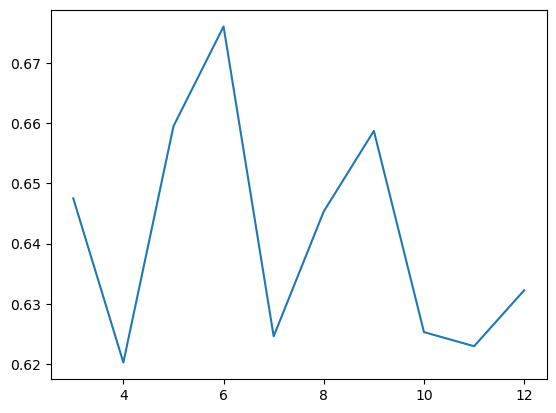

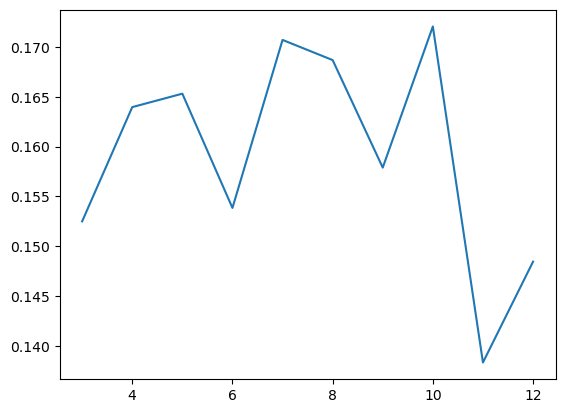

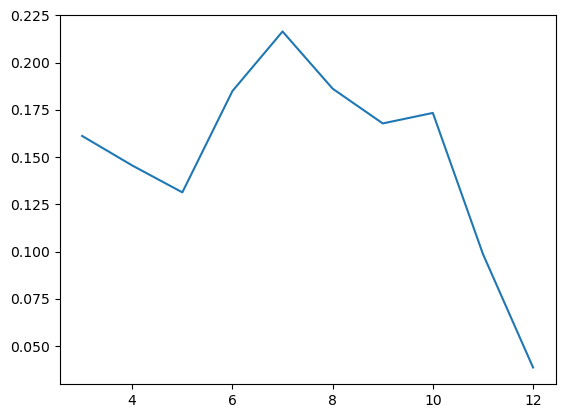

In [7]:
import matplotlib.pyplot as plt

plt.plot(all_data["replicate"], all_data["roc_auc"])
plt.show()

plt.plot(all_data["replicate"], all_data["ndcg"])
plt.show()


plt.plot(all_data["replicate"], all_data["top_k_recall"])
plt.show()


plt.plot(all_data["replicate"], all_data["spearman_rho"])
plt.show()